In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Data/Real-Data/Real_Combine.csv')
df = df.dropna()

In [4]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Decision tree regressor

In [8]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor(criterion="mse")

In [9]:
dtree.fit(x_train,y_train)

DecisionTreeRegressor()

In [11]:
dtree.score(x_test,y_test)

0.2848703735061483

In [12]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dtree,x,y,cv=5)
score.mean()

0.08244855841878536

# Visualization

In [14]:
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus

In [16]:
features = list(df.columns[:-1])
features

['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM']

In [18]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#you can dowload the tree and then see the nodes

In [20]:
prediction = dtree.predict(x_test)

c:\users\ameya gupta\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM 2.5', ylabel='Density'>

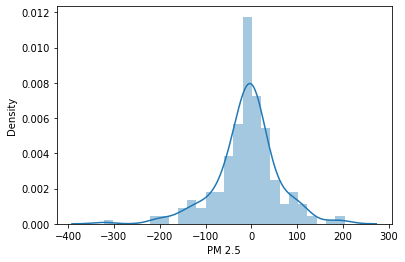

In [21]:
sns.distplot(y_test-prediction)

# Hyper-parameter tuning

In [22]:
DecisionTreeRegressor? #to explore the parameters to perform hyper tuning

In [23]:
params = {
    "splitter"    : ["best","random"] ,
    "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    "min_samples_leaf" : [ 1,2,3,4,5 ],
    "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
    "max_features" : ["auto","log2","sqrt",None ],
    "max_leaf_nodes":[None,10,20,30,40,50,60,70]   
}

In [25]:
## Hyperparameter optimization using GridSearchCV
from sklearn.model_selection import GridSearchCV 
#uses all permutaions/combinations of params and select which gives best result

In [26]:
random_search = GridSearchCV(dtree,param_grid=params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)

In [28]:
from datetime import datetime
start_time = datetime.now()
random_search.fit(x,y)
print(datetime.now() - start_time)

Fitting 10 folds for each of 10240 candidates, totalling 102400 fits
0:03:23.467567


In [29]:
random_search.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': 20,
 'min_samples_leaf': 4,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'random'}

In [30]:
random_search.best_score_

-3172.7308541305247

In [31]:
predictions = random_search.predict(x_test)

# Model evaluation

In [32]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 46.894254185692546
MSE: 4668.47621638762
RMSE: 68.32624837050268


In [33]:
import pickle
file = open('decision_regression_model.pkl', 'wb')
pickle.dump(random_search, file)
file.close()

# Random forest regressor
        The rest of the steps are same as decision tree regressor

In [34]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(x_train,y_train)

RandomForestRegressor()

In [36]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,x,y,cv=5)
score.mean()

0.49669378181646007

In [37]:
prediction = regressor.predict(x_test)

c:\users\ameya gupta\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PM 2.5', ylabel='Density'>

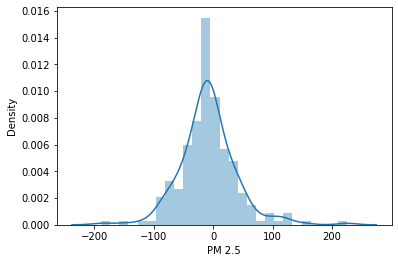

In [38]:
sns.distplot(y_test-prediction)

In [40]:
RandomForestRegressor? #to explore the hyper parameters 

In [42]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)] #12 equal gaps
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

In [43]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}


In [44]:
rf = RandomForestRegressor()

In [45]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [47]:
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.3s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_es

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time=   1.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=10, max_features

[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=100, n_estimators=300; total time=   0.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_featu

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.4s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=900; total time=   1.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=   0.2s
[CV] END max_depth=15, max_feature

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=1200; total time=   1.3s
[CV] END max_depth=10, max_

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=500; total time=   0.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.5s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END max_depth=30,

[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.4s
[CV] END max_depth=15, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=300; total time=   0.5s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.2s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.1s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   2.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_fe

[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.0s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=1100; total time=   1.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.4s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, m

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [48]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30}

In [49]:
rf_random.best_score_

-2584.2577313571037

In [51]:
predictions = rf_random.predict(x_test)

In [52]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 34.560149353120245
MSE: 2354.947902714588
RMSE: 48.52780545949495


In [53]:
import pickle
file = open('random_forest_regression_model.pkl', 'wb')
pickle.dump(random_search, file)
file.close()